Staging DataHub handles 200 queries per day. How long until it receives the next query request?

In [1]:
import csv
from datetime import datetime
import seaborn as sns

def parse_arrivals(csv_path, timestamp_col_idx, timestamp_format):
    arrivals = []
    with open(csv_path) as f:
        csv_reader = csv.reader(f)
        # skip header
        next(csv_reader)
        for row in csv_reader:
            arrivals.append(datetime.strptime(row[timestamp_col_idx], timestamp_format))
    arrivals = sorted(arrivals)
    return arrivals

def time_diffs(arrivals):
    return [
        (arrivals[i] - arrivals[i-1]).total_seconds()
        for i in range(1, len(arrivals))
    ]

<AxesSubplot:ylabel='Count'>

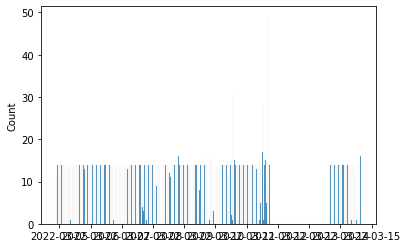

In [2]:
fedsql_arrivals = fedsql_arrivals = parse_arrivals(
    'data/datadog/extract-2022-03-14_16-53-83.csv',
    timestamp_col_idx=0,
    timestamp_format='%Y-%m-%dT%H:%M:%S.%fZ'
)
# the entries every 10 minutes are healthchecks, discard them
fedsql_arrivals = [a for a in fedsql_arrivals if not (a.minute % 10 == 0 and a.second < 10)]
fedsql_diffs = time_diffs(fedsql_arrivals)
sns.histplot(fedsql_arrivals, bins=1000)

<AxesSubplot:ylabel='Count'>

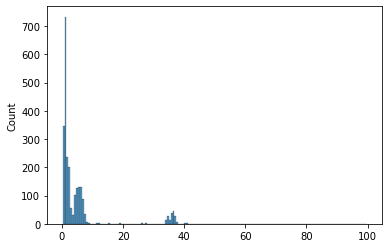

In [3]:
sns.histplot([d for d in fedsql_diffs if d < 100])

Let's take a look at a more comprehensive dataset. We'll use a [health ecommerce website visits dataset from Kaggle](https://www.kaggle.com/datasets/rajeck/health-ecommerce-website-visits)

<AxesSubplot:ylabel='Count'>

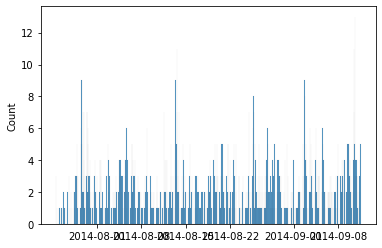

In [4]:
ecommerce_arrivals = parse_arrivals(
    'data/kaggle/health-ecommerce-website.csv',
    timestamp_col_idx=0,
    timestamp_format='%Y-%m-%d %H:%M'
)
ecommerce_diffs = time_diffs(ecommerce_arrivals)
sns.histplot(ecommerce_arrivals, bins=1000)

<AxesSubplot:ylabel='Count'>

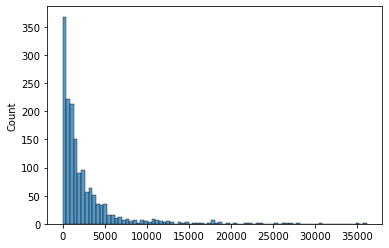

In [5]:
sns.histplot(ecommerce_diffs)

This looks like an [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution)!

In [6]:
# the rate, in arrivals/sec
time_span = (ecommerce_arrivals[-1] - ecommerce_arrivals[0]).total_seconds()
_lambda = len(ecommerce_arrivals) / time_span
_lambda

0.00038463582815089707

In [7]:
import numpy as np
from scipy.stats import expon
import matplotlib.pyplot as plt

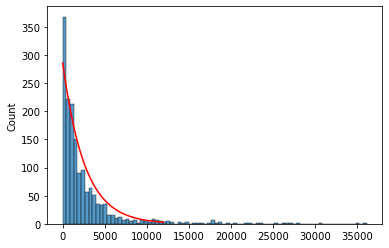

In [8]:
scale = 1/_lambda
ax = sns.histplot(ecommerce_diffs)
x = np.linspace(expon.ppf(0.01, scale=scale), expon.ppf(0.99, scale=scale), 100)
ax.plot(x, expon.pdf(x, scale=scale)*750_000, 'r-') # not sure why *750_000 is needed to match the scale

## Exponential Distribution

Probability density function | Cumulative distribution function
:--------------------------- | :-------------------------------
![](Exponential_pdf.svg)     | ![](Exponential_cdf.svg)
_[by Newystats - Own work, CC BY-SA 4.0](https://commons.wikimedia.org/w/index.php?curid=80359746)_ | _[by Skbkekas - Own work, CC BY 3.0]( https://commons.wikimedia.org/w/index.php?curid=9508326)_

If something happens $\lambda = 1.5$ times a second, there is ~80% chance it will happen within one second.

$E[X] = \frac{1}{\lambda}$

$\lambda = \frac{200}{8 \times 60} = \frac{5}{12}$ messages per minute

$E[X] =$ 2.4 minutes = 2 minutes 24 seconds

In [9]:
from scipy.stats import expon
_lambda = 200 / (8*60)
expon.expect(scale = 1/_lambda)

2.3999999999999995

## Markov chains


In [29]:
%%bash
cat > tmp.dot <<EOF
digraph G {
  rankdir="LR";
  Sunny -> Sunny [label="0.9"];
  Sunny -> Rainy [label="0.1"];
  Rainy -> Rainy [label="0.5"];
  Rainy -> Sunny [label="0.5"];
}
EOF

In [33]:
from IPython.core.display import SVG

def show_graph():
    res = !dot -Tsvg tmp.dot
    return SVG("".join(res))

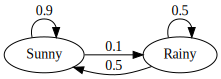

In [34]:
show_graph()

## Continuous time Markov chains

Each edge has a transition rate. When we enter a state, we start exponentially-distributed clock for each outgoing edge and follow the one that ticks first, discarding other clocks.

Example: we have broadband and mobile internet connection. The broadband fails on average once a year and takes a day to fix. Mobile fails once a month and takes an hour to fix. How long in a give year are we going to be without the Internet?

In [43]:
%%bash
cat > tmp.dot <<EOF
digraph G {
  rankdir="LR";
  
  "B|M" -> "_|M" [label="1/365"];
  "_|M" -> "B|M" [label="1"];
  "B|M" -> "B|_" [label="1/30"];
  "B|_" -> "B|M" [label="24"];
  "_|M" -> "_|_" [label="1/30"];
  "B|_" -> "_|_" [label="1/365"];
  "_|_" -> "B|_" [label="1"];
  "_|_" -> "_|M" [label="24"];
  { rank=same; "B|_"; "_|M" }
}
EOF

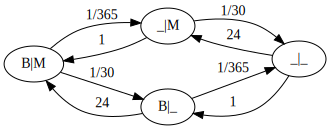

In [46]:
show_graph()

$\pi(s)$ -- the average time spent in state $s$; the _equilibrium_; can be computed from equations:

* $\sum\pi(s)=1$
* for all $s\in S$ $\sum\limits_{t\in S} R(t,s)\pi(t)=\pi(s)\sum\limits_{u\in S} R(s,u)$ (flow equations: lhs is the flow in, rhs is flow out)

Easier form for _reversible_ CTMCs:

$$\pi(s)R(s,t) = \pi(t)R(t,s)$$

This one is reversible (product of rates in every cycle of length 3+ equals the product in the same cycle reversed), so:

In [56]:
             # B|M    _|M   B|_    _|_
A = np.array([[1/365, -1,   0,     0  ],  #  B|M  <->  _|M
              [1/30,  0,    -24,   0  ],  #  B|M  <->  B|_
              [0,     1/30, 0,     -24],  #  _|M  <->  _|_
#             [0,     0,    1/365, -1 ],  #  B|_  <->  _|_
              [1,     1,    1,      1 ],  # sum = 1
             ])
y = np.array([0, 0, 0, 1])

pi = np.linalg.solve(A, y)
print(pi)
print(pi[3]*(365*24*60))

[9.95884587e-01 2.72845092e-03 1.38317304e-03 3.78951517e-06]
1.9917691730519995


Note: we didn't need all 4 flow equations, one was redundant; on the other hand we need the final $\sum=1$ condition. Removing any other equation does not change the result.

# Queues

X/Y/m/n

* **X**: arrival distribution, **Y**: departure (service time) distribution:
    * D - deterministic
    * M - Markovian (exponentially distributed)
    * G - general
* **m**: the number of servers
* **n**: capacity (infinity if not specified)

## D/D/1

Example: arrivals every 1s, service time 0.5s

Occupancy $L$:

* $P(L=0) = 0.5$
* $P(L=1) = 0.5$

## M/M/1

* arrival rate: l ($\lambda$)
* service time rate: m ($\mu$)

In [62]:
%%bash
cat > tmp.dot <<EOF
digraph G {
  rankdir="LR";
  0 -> 1 [label="l"];
  1 -> 2 [label="l"];
  2 -> 3 [label="l"];
  3 -> "..." [label="l"];
  "..." -> 3 [label="m"];
  3 -> 2 [label="m"];
  2 -> 1 [label="m"];
  1 -> 0 [label="m"];
  "..." [shape=none];
}
EOF

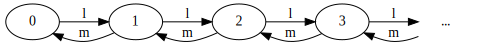

In [63]:
show_graph()

Occupancy:

- $P(L=n) = \left(1-\frac{\lambda}{\mu}\right)\left(\frac{\lambda}{\mu}\right)^n$
- $E(L) = \frac{\lambda/\mu}{1-\lambda/\mu}$

Utilisation:

- $\rho=1-P(L=0)=\frac{\lambda}{\mu}$

Response time:

- $E(W) = \frac{1}{\mu(1-\rho)} = \frac{1}{\mu-\lambda}$

Busy period:

- $E(B)=\frac{1}{\mu(1-\rho)}$

# Aside: Little's law

$$L=\lambda W$$

Where:

- $W$: average response time
- $L$: average occupancy
- $\lambda$: arrival rate

Holds for (almost) any possible system.

## M/G/1

Need to know something about the service times; if $S$ is the random variable describing service time, we will take:

- $\mu=\frac{1}{E(S)}$
- $C^2_S = \frac{V(S)}{E(S)^2}$ – coefficient of variation; to account for $S$ not being exponential

Utilisation:

- $\rho=\frac{\lambda}{\mu}$

Occupancy:

- $E(L) = \frac{\rho}{1-\rho}(s-\frac{1}{2}\rho(1-C^2_S))$

Response time:

- $E(W) = \frac{1}{\mu(1-\rho)}\left(1-\frac{1}{2}\rho(1-C_S^2)\right)$

Busy period:

- $E(B) = \frac{1}{\rho-\lambda}$

## M/M/c

In [66]:
%%bash
cat > tmp.dot <<EOF
digraph G {
  rankdir="LR";
  0 -> 1 [label="l"];
  1 -> 0 [label="m"];
  1 -> 2 [label="l"];
  2 -> 1 [label="2m"];
  2 -> e1 [label="l"];
  e1 -> 2 [label="3m"];
  e1 -> "c-1" [label="l"];
  "c-1" -> e1 [label="(c-1)m"];
  "c-1" -> c [label="l"];
  c -> "c-1" [label="cm"];
  c -> "c+1" [label="l"];
  "c+1" -> c [label="cm"];
  "c+1" -> e2 [label="l"];
  e2 -> "c+1" [label="cm"];
  e1 [shape=none,label="..."];
  e2 [shape=none,label="..."];
}
EOF

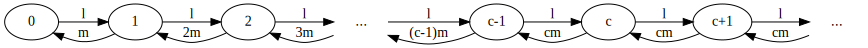

In [67]:
show_graph()

Occupancy:

- $P(L=j) = \pi(j) = \begin{cases} \left(1+\frac{\rho^c}{(c-\rho)(c-1)!}+\sum\limits_{k=0}^{c-1}\frac{\rho^k}{k!}\right)^{-1} & \text{if } j=0,\\ \pi(0)\frac{\rho^j}{j!} & \text{if } 0<j<c,\\ \pi(0)c^{c-j}\frac{\rho^j}{c!} & \text{if } j\geq c \end{cases}$
- $E(L) = \pi(0)\frac{\rho^c(c^2-c\rho+\rho)}{(c-\rho)^2(c-1)!}+\pi(0)\sum\limits_{j=1}^{c-1}\frac{\rho^i}{(j-1)!}$

## M/M/1/n

In [70]:
%%bash
cat > tmp.dot <<EOF
digraph G {
  rankdir=LR;
  0 -> 1 [label="l"];
  1 -> 0 [label="m"];
  1 -> 2 [label="l"];
  2 -> 1 [label="m"];
  2 -> "..." [label="l"];
  "..." -> 2 [label="m"];
  "..." -> "n" [label="l"];
  "n" -> "..." [label="m"];
  "..." [shape=none];
}
EOF

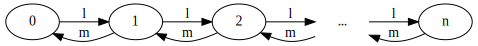

In [71]:
show_graph()

Occupancy:

- $P(L=j)=\frac{\rho^j(1-\rho)}{1-\rho^{n+1}}$
- $E(L) = (\frac{\rho}{1-\rho})\frac{1-\rho^n(n+1-n\rho)}{1-\rho^{n+1}}$

Blocking probability:

- $P_B=P(L=n)$

Throughput:

- $\gamma=\lambda(1-P_B)$

## M/M/n/n

In [72]:
%%bash
cat > tmp.dot <<EOF
digraph G {
  rankdir=LR;
  0 -> 1 [label="l"];
  1 -> 0 [label="m"];
  1 -> 2 [label="l"];
  2 -> 1 [label="2m"];
  2 -> "..." [label="l"];
  "..." -> 2 [label="3m"];
  "..." -> "n" [label="l"];
  "n" -> "..." [label="nm"];
  "..." [shape=none];
}
EOF

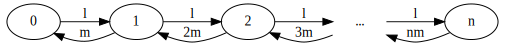

In [73]:
show_graph()

Occupancy:

- $P(L=0)=\pi(0)=(\sum\limits_{j=0}^{n}\rho^j/j!)^{-1}$
- $P(L=j)=\pi(0)(\rho^j/j!)$

# Networks of queues

![](dh-flow.svg) 

![](dh-queues.svg)